In [14]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

# Text generation with LSTM

This notebook contains the code samples found in Chapter 8, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

[...]

## Implementing character-level LSTM text generation


Let's put these ideas in practice in a Keras implementation. The first thing we need is a lot of text data that we can use to learn a 
language model. You could use any sufficiently large text file or set of text files -- Wikipedia, the Lord of the Rings, etc. In this 
example we will use some of the writings of Nietzsche, the late-19th century German philosopher (translated to English). The language model 
we will learn will thus be specifically a model of Nietzsche's writing style and topics of choice, rather than a more generic model of the 
English language.

## Preparing the data

Let's start by downloading the corpus and converting it to lowercase:

In [15]:
import keras
import numpy as np


# 加载数据集
path = keras.utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()  # 全部小写
print('Corpus length:', len(text))

Corpus length: 600893



Next, we will extract partially-overlapping sequences of length `maxlen`, one-hot encode them and pack them in a 3D Numpy array `x` of 
shape `(sequences, maxlen, unique_characters)`. Simultaneously, we prepare a array `y` containing the corresponding targets: the one-hot 
encoded characters that come right after each extracted sequence.

In [16]:
# Length of extracted character sequences,每个sample的长度
maxlen = 60

# We sample a new sequence every `step` characters，每隔3步取一个数据作为sample
step = 3

# This holds our extracted sequences，句子
sentences = []

# This holds the targets (the follow-up characters)，标签
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))

# List of unique characters in the corpus，为了做映射表，有58个字符
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)


# 进行one-hot编码
# Next, one-hot encode the characters into binary arrays.
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
    
# 构建数据完成

Number of sequences: 200278
Unique characters: 58
Vectorization...


## Building the network

Our network is a single `LSTM` layer followed by a `Dense` classifier and softmax over all possible characters. But let us note that 
recurrent neural networks are not the only way to do sequence data generation; 1D convnets also have proven extremely successful at it in 
recent times.

In [17]:
from keras import layers

# 搭建很简单的网络
model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

Since our targets are one-hot encoded, we will use `categorical_crossentropy` as the loss to train the model:

In [18]:
# 优化器
optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

## Training the language model and sampling from it


Given a trained model and a seed text snippet, we generate new text by repeatedly:

* 1) Drawing from the model a probability distribution over the next character given the text available so far
* 2) Reweighting the distribution to a certain "temperature"
* 3) Sampling the next character at random according to the reweighted distribution
* 4) Adding the new character at the end of the available text

This is the code we use to reweight the original probability distribution coming out of the model, 
and draw a character index from it (the "sampling function"):

In [19]:
# 对最终的预测概率进行放缩、拉伸，拉大距离，让抽样距离更加大
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)   # 返回最大的可能的字符


Finally, this is the loop where we repeatedly train and generated text. We start generating text using a range of different temperatures 
after every epoch. This allows us to see how the generated text evolves as the model starts converging, as well as the impact of 
temperature in the sampling strategy.

In [21]:
import random
import sys


# 训练59个ephoch
for epoch in range(1, 2):
    print('epoch', epoch)
    # Fit the model for 1 epoch on the available training data
    model.fit(x, y,
              batch_size=128,
              epochs=1)

    # Select a text seed at random，做验证
    start_index = random.randint(0, len(text) - maxlen - 1)
    origal_generated_text = text[start_index: start_index + maxlen]
    print('--- Generating with seed: "' + origal_generated_text + '"')

    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        sys.stdout.write(origal_generated_text)

        # We generate 400 characters
        # 不同之处在于origal_generated_text
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(origal_generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]  # 生成是二维的，只有一个sample，所以是[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text =origal_generated_text+ next_char
        generated_text = generated_text[1:]

        # 打印
        sys.stdout.write(next_char)

        for i in range(399):
            # one-hot encoding
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]  # 生成是二维的，只有一个sample，所以是[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            # 打印
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
Epoch 1/1
200278/200278 [==============================] - 283s 1ms/step - loss: 1.6169
--- Generating with seed: " under their dress and finery.

128. the more abstract the t"
------ temperature: 0.2


NameError: name 'generated_text' is not defined

In [2]:
import sys
t = 'As you can see, a low temperature results in extremely repetitive and predictable text,\
     but where local structure is highly realistic: in particular, all words (a word being a\
     local pattern of characters) are real English words. With higher temperatures, the generated\
     text becomes more interesting, surprising, even creative; it may sometimes invent completely new\
     words that sound somewhat plausible (such as "eterned" or "troveration"). With a high temperature,\
     the local structure starts breaking down and most words look like semi-random strings of characters.\
     Without a doubt, here 0.5 is the most interesting temperature for text generation in this specific setup.\
     Always experiment with multiple sampling strategies! A clever balance between learned structure and randomness\
     is what makes generation interesting.'
for i in t:
    sys.stdout.write(i)  # print(i) = sys.stdout.write(i+ \n)，一次性输出
    sys.stdout.flush() # 缓冲输出，刷新区域

As you can see, a low temperature results in extremely repetitive and predictable text,     but where local structure is highly realistic: in particular, all words (a word being a     local pattern of characters) are real English words. With higher temperatures, the generated     text becomes more interesting, surprising, even creative; it may sometimes invent completely new     words that sound somewhat plausible (such as "eterned" or "troveration"). With a high temperature,     the local structure starts breaking down and most words look like semi-random strings of characters.     Without a doubt, here 0.5 is the most interesting temperature for text generation in this specific setup.     Always experiment with multiple sampling strategies! A clever balance between learned structure and randomness     is what makes generation interesting.

 
       █　　　　　█　█ 　　　　 　     
　     █　　　█████　　　　 
       █　　   　 █　　　　   　 
　     █      █████　　  　　████████   
       █      █  █  █　   　　 █            █
　 █████　█████　　      █            █
　     █　　　█　█　█　　　　　█　　　　　　█
　     █　　  █████          ████████
       █   　 █  █  █                █ █
       █   　 █  ███               █   █
       █             █               █     █
       █    █　█　█　█　　　　   █      █
　     █　　      █ █　　　　　　█　　　  █
　     █　　　 █  █　　　　　　█　        █      █
　     █　　　　    █　　　　██            ████
       █　　　　 ██　　　　　　                         
       
            ┊┊┊
            ┊┊┊┊☆☆☆☆☆☆☆☆
            ┊┊┊╭┻┻┻┻┻┻┻┻╮┊┊┊
            ┊┊┊┃╱╲╱╲╱╲╱╲┃┊┊┊
            ┊┊╭┻━━━━━━━━┻╮┊┊
            ┊┊┃╱╲╱╲╱╲╱╲╱╲┃┊┊
            ╱▔┗━━━━━━━━━━┛▔╲     
            
                ◢████████████◣                
               ██████████████                
               ██       ◥██◤       ██                
           ◢███         ◥◤         ██◣              
           ▊▎

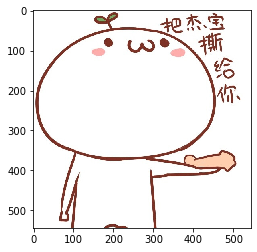

<Figure size 432x288 with 0 Axes>

In [9]:
t =""" 
       █　　　　　█　█ 　　　　 　     
　     █　　　█████　　　　 
       █　　   　 █　　　　   　 
　     █      █████　　  　　████████   
       █      █  █  █　   　　 █            █
　 █████　█████　　      █            █
　     █　　　█　█　█　　　　　█　　　　　　█
　     █　　  █████          ████████
       █   　 █  █  █                █ █
       █   　 █  ███               █   █
       █             █               █     █
       █    █　█　█　█　　　　   █      █
　     █　　      █ █　　　　　　█　　　  █
　     █　　　 █  █　　　　　　█　        █      █
　     █　　　　    █　　　　██            ████
       █　　　　 ██　　　　　　                         
       
            ┊┊┊
            ┊┊┊┊☆☆☆☆☆☆☆☆
            ┊┊┊╭┻┻┻┻┻┻┻┻╮┊┊┊
            ┊┊┊┃╱╲╱╲╱╲╱╲┃┊┊┊
            ┊┊╭┻━━━━━━━━┻╮┊┊
            ┊┊┃╱╲╱╲╱╲╱╲╱╲┃┊┊
            ╱▔┗━━━━━━━━━━┛▔╲     
            
                ◢████████████◣                
               ██████████████                
               ██       ◥██◤       ██                
           ◢███         ◥◤         ██◣              
           ▊▎██◣                  ◢█▊▊              
           ▊▎██◤     ●     ●      ◥█▊▊            
           ▊   ██                     █▊▊              
           ◥▇██   ▊             ▊   █▇◤              
               ██   ◥▆▄▄▄▄▆◤   █▊       ◢▇▇◣  
        ◢██◥◥▆▅▄▂▂▂▂▄▅▆███◣ ▊ ◢   █  
        █╳                              ╳█   ◥◤◢◤  
        ◥█◣       ˙           ˙     ◢█◤     ◢◤    
             ▊                          ▊         █      
             ▊                          ▊       ◢◤      
             ▊             ⊕            █▇▇▇◤      
           ◢█▇▆▆▆▅▅▅▅▆▆▆▇█◣  
           
           。'ㅇ'☆''。*。*.。'☆*。。'ㅇ.☆.。'..*。*。..。'ㅇ'。 
.。'☆。' 　 ◆◆◆◆　'☆*。.*ㅇ ◆◆◆◆　 .。'☆。' 
. 。' ' 　◆◆◆◆◆◆◆ *☆ ◆◆◆◆◆◆◆◆　 .。' ' 
'。☆　◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆　 ''。☆ 
.。 　 ◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆　.*ㅇ 
'☆　◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆　 .。 
.*ㅇ ◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆　''☆ 
''☆　◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆　.☆. 
.☆. 　◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆　.*ㅇ 
ㅇ'.. 　 ◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆◆　 。''☆ 
。''☆''。　 ◆◆◆◆◆◆◆◆◆◆◆◆◆◆　 。'。'☆''。 
*。..。'ㅇ'.。　 ◆◆◆◆◆◆◆◆◆◆　 *。..☆。'ㅇ'.。 
☆''。*。.。'ㅇ. 　 ◆◆◆◆◆◆◆ 　☆'。*.☆。'ㅇ'.。 
☆''。*。*.。'ㅇ..☆..　◆◆◆◆　 ☆''。*☆。'ㅇ'.。'☆ 
☆''。*。*.。'ㅇ..☆..☆　 ◆　 ☆''。*...☆。'ㅇ'.。'☆ 
。　　　．　 . 　 　˚　 .　　 ˙　。　.　 
　　　.　°　 ★　 .　˚　 .　˙　。　 ． .　 �
   
   
       
        ◆  ◆ ◆ ◆       ◆         ◆  ◆ ◆ ◆
                  ◆       ◆         ◆        ◆
                  ◆     ◆◆◆       ◆        ◆
        ◆  ◆  ◆◆       ◆         ◆        ◆
                  ◆       ◆         ◆        ◆
                  ◆       ◆         ◆        ◆
        ◆  ◆  ◆◆       ◆         ◆  ◆ ◆ ◆   
                   
###########################################################################################        
        
        
        forever forever               forever forever             forever forever forever
        forever forever               forever forever             forever forever forever           
                forever                   forever                 forever forever forever
                    forever               forever                 forever         forever
                    forever               forever                 forever         forever
                    forever               forever                 forever         forever
                      forever             forever                 forever         forever
        forever forever forever           forever                 forever         forever
        forever forever forever           forever                 forever         forever
                      forever             forever                 forever         forever
                    forever               forever                 forever         forever
                    forever               forever                 forever         forever
                    forever               forever                 forever         forever
                   forever                forever                 forever forever forever
        forever forever               forever forever             forever forever forever
        forever forever               forever forever             forever forever forever
 

 ########################################################################################### """  
for i in t:
    sys.stdout.write(i)  # print(i) = sys.stdout.write(i+ \n)，一次性输出
    sys.stdout.flush() # 缓冲输出，刷新区域
print('',end='')
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
path = r'C:\Users\Administrator\Desktop\1.jpeg'
plt.imshow(load_img(path))
plt.figure()
plt.show()
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    

In [ ]:

As you can see, a low temperature results in extremely repetitive and predictable text, but where local structure is highly realistic: in 
particular, all words (a word being a local pattern of characters) are real English words. With higher temperatures, the generated text 
becomes more interesting, surprising, even creative; it may sometimes invent completely new words that sound somewhat plausible (such as 
"eterned" or "troveration"). With a high temperature, the local structure starts breaking down and most words look like semi-random strings 
of characters. Without a doubt, here 0.5 is the most interesting temperature for text generation in this specific setup. Always experiment 
with multiple sampling strategies! A clever balance between learned structure and randomness is what makes generation interesting.

Note that by training a bigger model, longer, on more data, you can achieve generated samples that will look much more coherent and 
realistic than ours. But of course, don't expect to ever generate any meaningful text, other than by random chance: all we are doing is 
sampling data from a statistical model of which characters come after which characters. Language is a communication channel, and there is 
a distinction between what communications are about, and the statistical structure of the messages in which communications are encoded. To 
evidence this distinction, here is a thought experiment: what if human language did a better job at compressing communications, much like 
our computers do with most of our digital communications? Then language would be no less meaningful, yet it would lack any intrinsic 
statistical structure, thus making it impossible to learn a language model like we just did.


## Take aways

* We can generate discrete sequence data by training a model to predict the next tokens(s) given previous tokens.
* In the case of text, such a model is called a "language model" and could be based on either words or characters.
* Sampling the next token requires balance between adhering to what the model judges likely, and introducing randomness.
* One way to handle this is the notion of _softmax temperature_. Always experiment with different temperatures to find the "right" one.